# الگوریتم Grover's

توی این نوت‌بوک، می‌خوایم یه مقدار جنبه‌های مختلف الگوریتم جست‌وجوی Grover رو بررسی کنیم.

In [22]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
from qiskit.quantum_info import random_statevector
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sim = Aer.get_backend('aer_simulator')
%matplotlib

Using matplotlib backend: agg


In [24]:
def get_statevector(qc: QuantumCircuit) -> np.ndarray:
    qc.save_statevector()
    qobj = assemble(qc)
    state = sim.run(qobj).result().get_statevector(qc)
    return state

## ۱. ساختن Oracle موردنیاز.
همون‌طور که از جلسات دوشنبه یادتون هست، Oracle توی الگوریتم Grover، قسمتی از مدار بود که مشخص می‌کرد می‌خوایم چه المان‌هایی (یا المان‌هایی با چه خاصیتی) رو از بین کل االمان‌های موجودمون پیدا کنیم. توی این قسمت می‌خوایم ببیینم که چه‌طور می‌شه این 
قسمت از مدار رو ساخت.

**یادآوری درس جلسات:**
توی الگوریتم Grover، وضعیت‌ها رو به این صورت بازنویسی می‌کردیم:

$$| s \rangle = H^{\otimes n} | 0 \rangle^n$$
$$|s\rangle = \sin \theta | w \rangle + \cos \theta | s' \rangle, \text{where } \theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$$

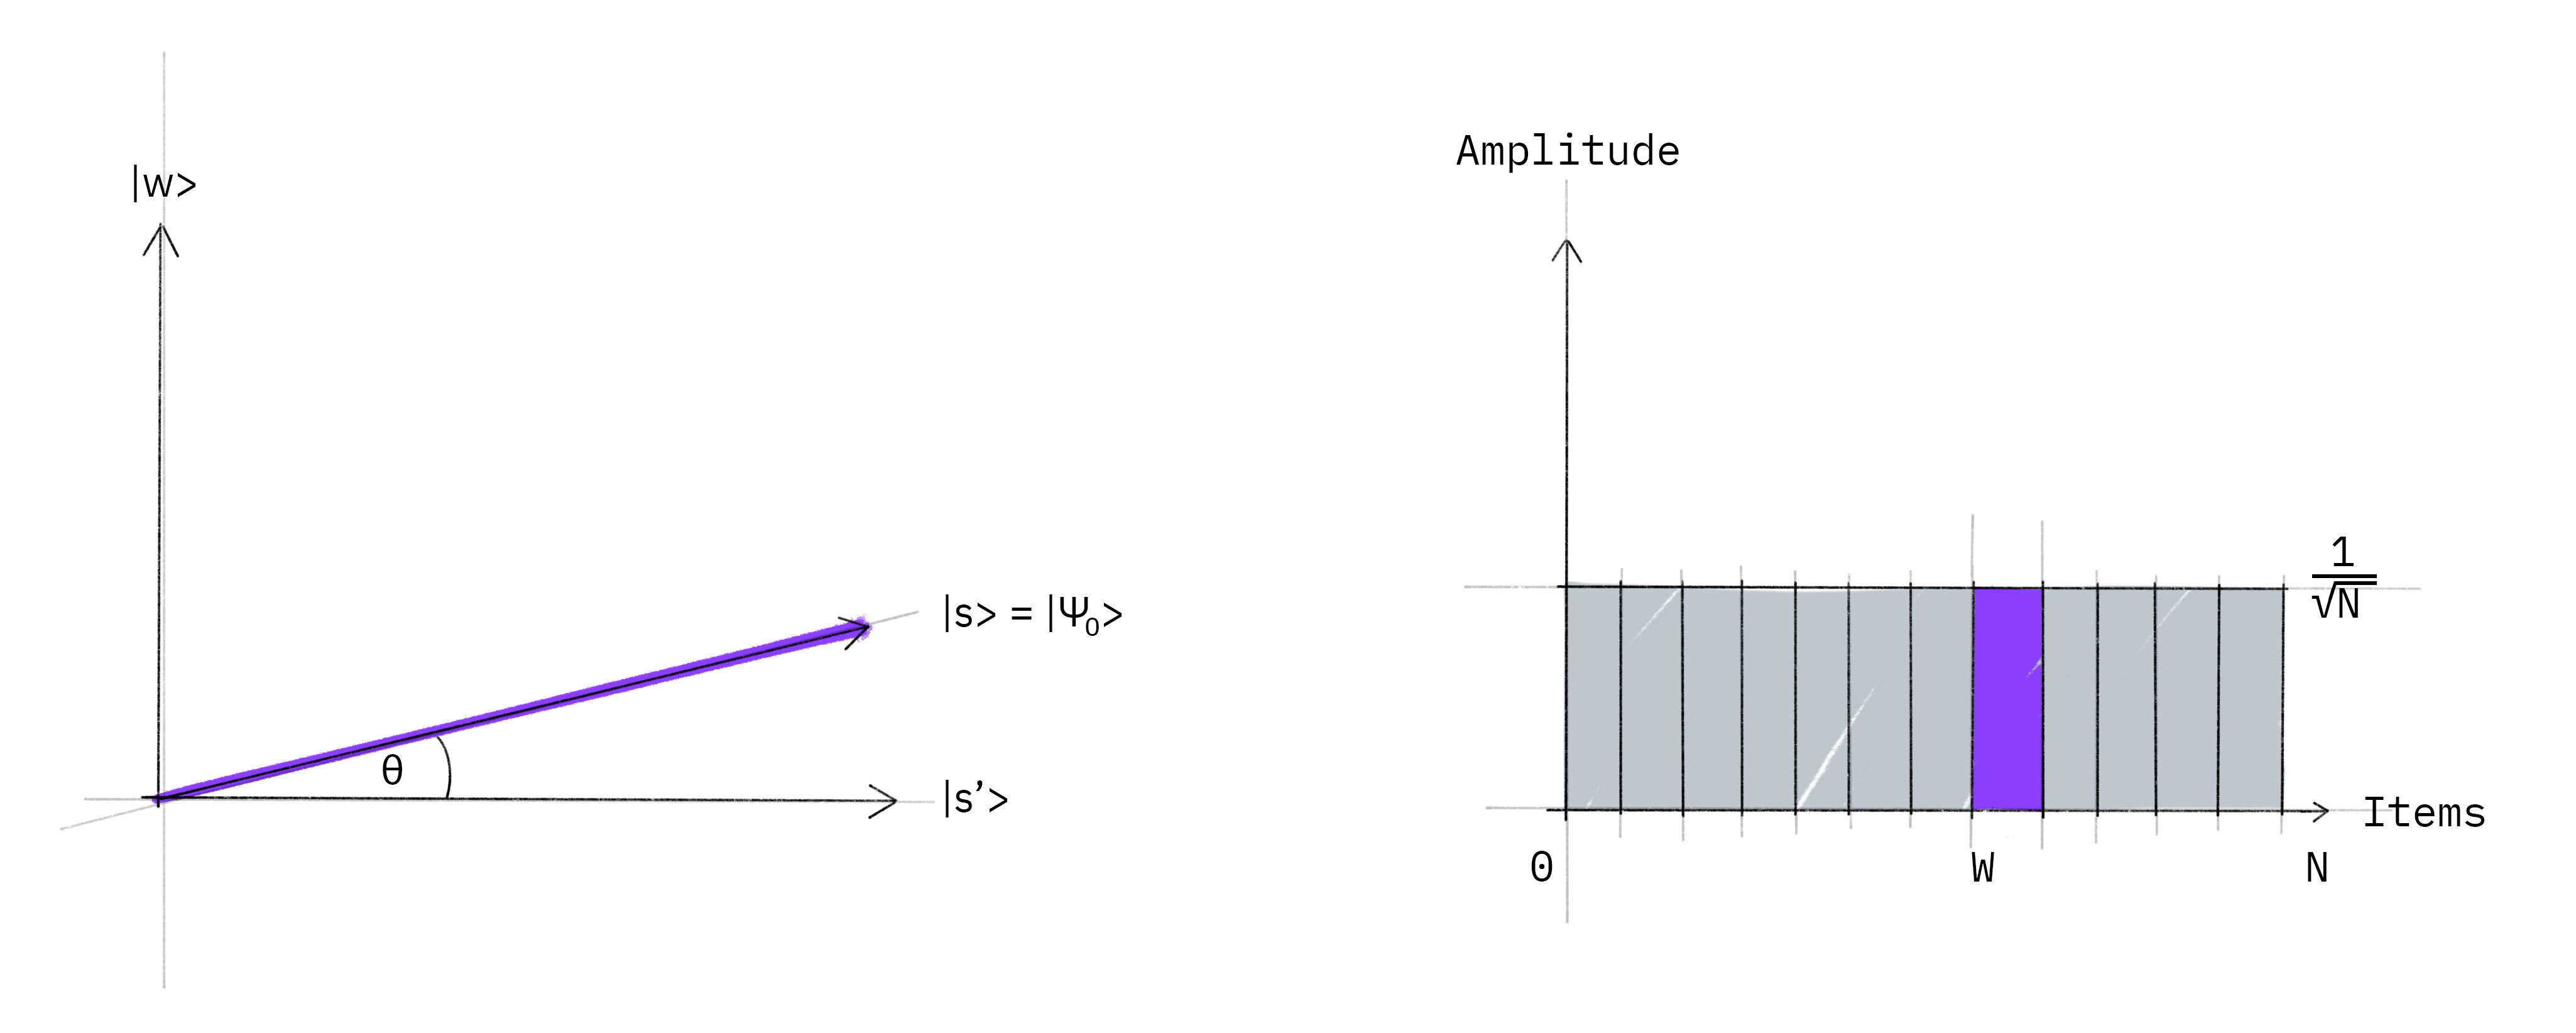

که $|\omega \rangle$ فضای حالت‌هایین که می‌خوایم پیداشون کنیم و $|s' \rangle$ فضای حالت‌هایین که کاری بهشون نداریم. 

اگه فرض کنیم یه تابع $f(x)$ داریم که برای المان‌هایی که می‌خوایم پیداشون کنیم جواب $1$ و برای بقیه مقادیر جواب $0$ برمی‌گردونه، می‌تونیم اوراکل‌مون رو به این صورت بنویسیم:

$$
U_\omega|x\rangle = (-1)^{f(x)}|x\rangle
$$

و برای پیاده‌سازی توی یه مدار کوانتومی، ماتریس‌ش به این صورت درمیاد:

$$
U_\omega = 
\begin{bmatrix}
(-1)^{f(0)} &   0         & \cdots &   0         \\
0           & (-1)^{f(1)} & \cdots &   0         \\
\vdots      &   0         & \ddots & \vdots      \\
0           &   0         & \cdots & (-1)^{f(2^n-1)} \\
\end{bmatrix}
$$

که با اعمالش به وضعیت‌مون (توی این شکل فرض می‌کنیم فقط ۱ جواب داریم) به این وضعیت می‌رسیم:

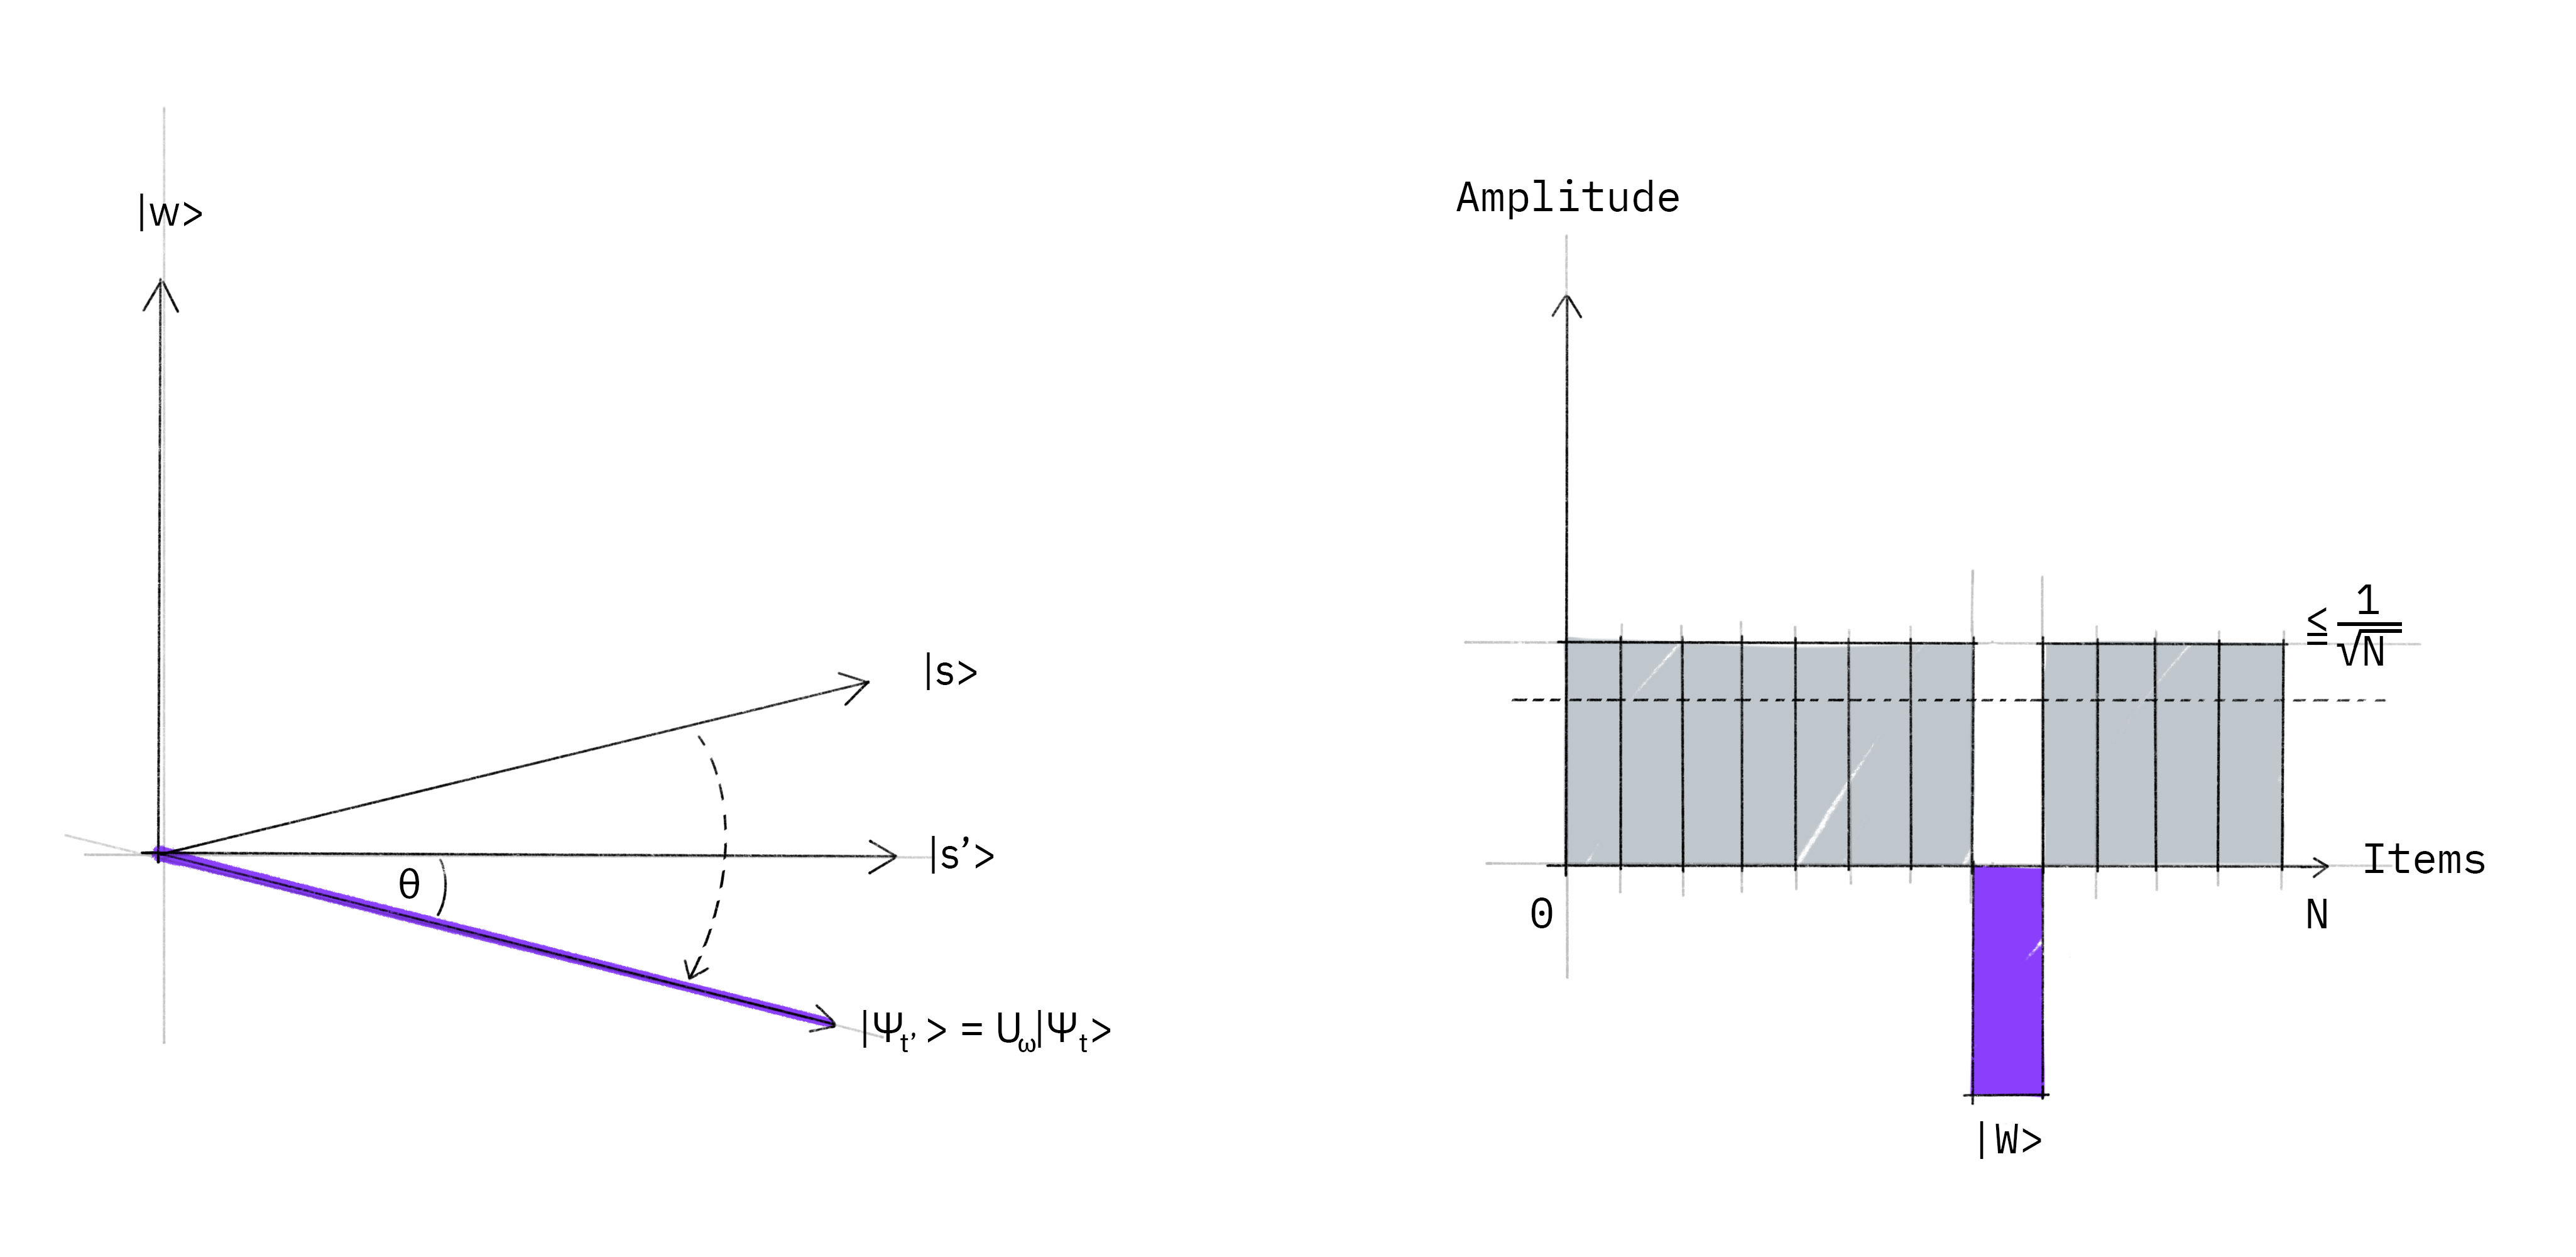

حالا می‌خوایم پیاده‌سازی چندتا Oracle رو تمرین کنیم.

### تمرین:

### ۱.۱.  $|11 \dots 1\rangle$

**ورودی:**

یه `QuantumCircuit` که کیوبیت‌هاشون توی یه استیت رندوم قرار دارن.

**هدف:**
ضریب وضعیت $|11...1\rangle$ ضرب‌در $-1$ بشه.
به طور مثال، اگه کیوبیت‌هامون توی وضعیت زیر باشن:

$$ |\psi\rangle = \alpha |0 \dots 0\rangle + \beta |0 \dots 1\rangle + \dots + \gamma |1 \dots 1\rangle $$

می‌خوایم با اجرای مدارمون، به این وضعیت بره:

$$ |\psi\rangle = \alpha |0 \dots 0\rangle + \beta |0 \dots 1\rangle + \dots - \gamma |1 \dots 1\rangle $$

In [ ]:
def all_ones_oracle(qc: QuantumCircuit) -> QuantumCircuit:
    n = qc.num_qubits
    qc.mcp(np.pi, [:n-2], n-1)

### ۲.۱. یه Bitstring از پیش تعیین نشده!

**ورودی:**

یه `str` که وضعیت دل‌خواه‌مون رو نشون می‌ده. مثلا: `0101000`

**هدف:**
ضریب وضعیت این bitstring ضرب‌در -۱ بشه.
به طور مثال، اگه کیوبیت‌هامون توی وضعیت زیر باشن:

$$ |\psi\rangle = \alpha |0 \dots 0\rangle + \beta |0 \dots 1\rangle + \dots \lambda |0101000\rangle+ \dots + \gamma |1 \dots 1\rangle $$

می‌خوایم با اجرای مدارمون، به این وضعیت بره:

$$ |\psi\rangle = \alpha |0 \dots 0\rangle + \beta |0 \dots 1\rangle + \dots - \lambda |0101000\rangle + \dots + \gamma |1 \dots 1\rangle $$ 

In [ ]:
def random_bitstring(n:int):
    from random import choice
    return ''.join(choice('01') for _ in range(n))

n = 4

bitstring = random_bitstring(n)

all_indices = list(range(n))
last_1 = bitstring.rfind('1')
zero_indices = [i for i, x in enumerate(bitstring) if x == "0"]
all_but_last_one = list(set(all_indices) ^ set([last_1]))

qc = QuantumCircuit(n)

for i in range(n):
    qc.h(i)

if last_1 == -1:
    pass
else:
    for i in zero_indices:
        qc.x(i)
    qc.mcp(np.pi, all_but_last_one, last_1)
    for i in zero_indices:
        qc.x(i)

# Does the job for the reverse string, because Qiskit is little-endian.
print(bitstring[::-1])

state = get_statevector(qc)
array_to_latex(state.reshape(16, 1), max_size=20)

### ۲. Diffuser یا ماتریس دوران

همون‌طور که یادتونه، توی الگوریتم Grover می‌خواستیم بعد از این‌که amplitude جواب‌هامون رو ضرب‌در -1 کردیم، حالت‌مون رو حول وضعیت $|s\rangle$ دوران می‌دادیم تا به این وضعیت برسیم:
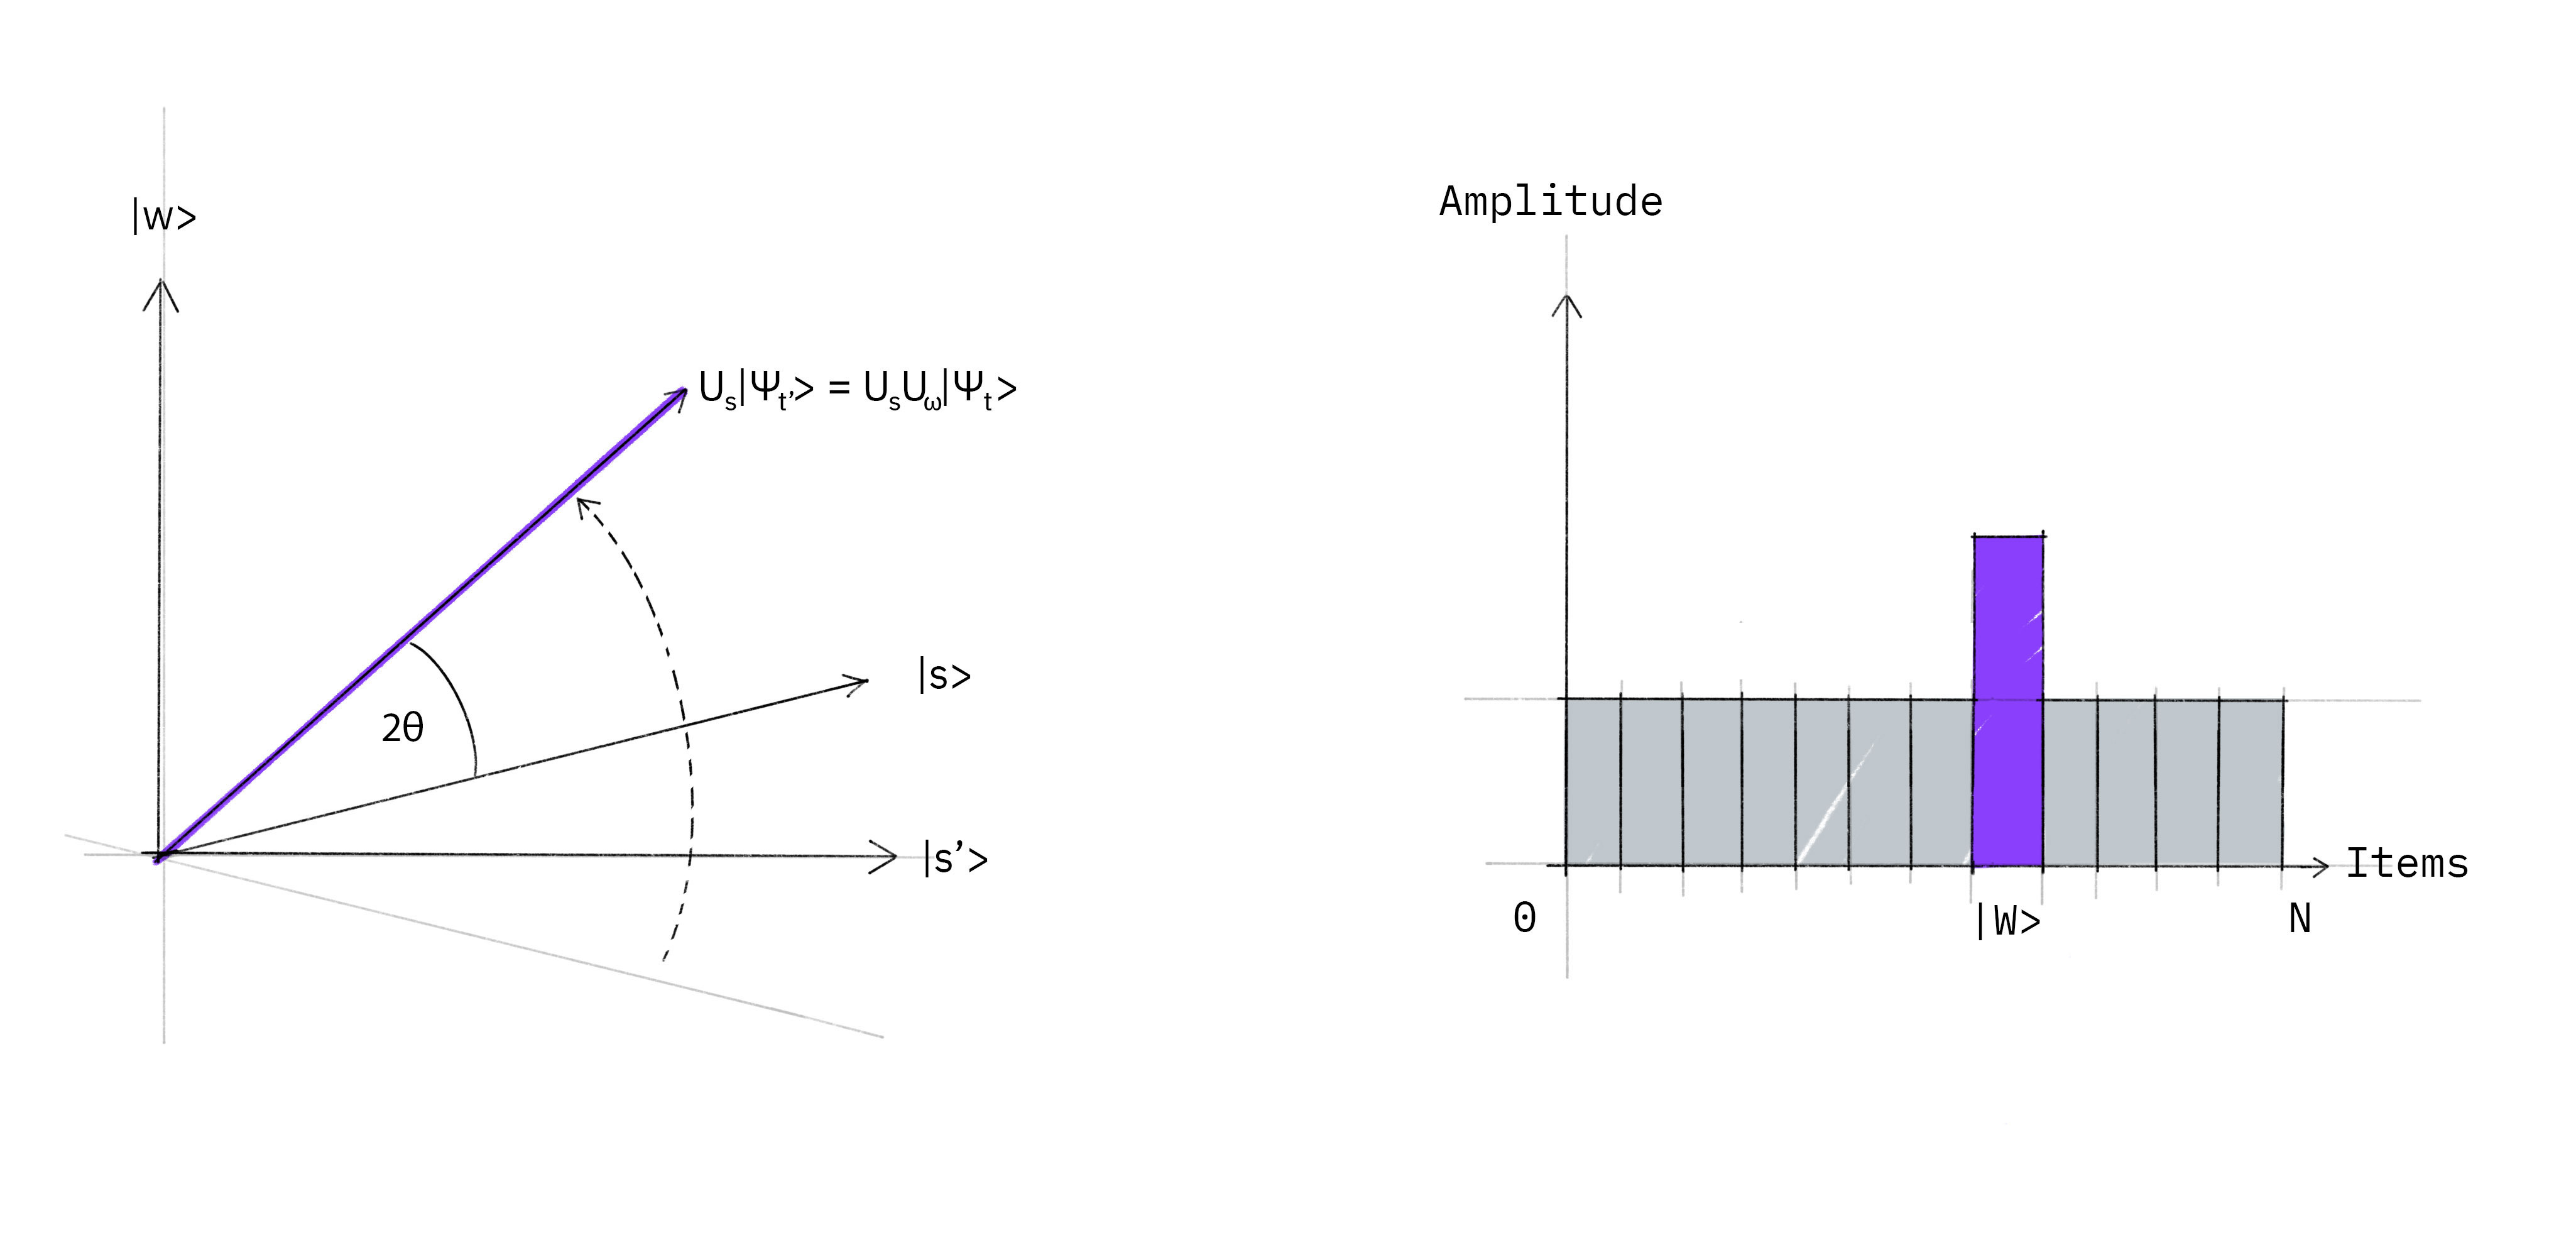

و توی نوتیشن دیراک، این دوران رو به این صورت می‌نویسیم:

$$ U_s = 2|s\rangle\langle s| - \mathbb{1}$$

یه روش که می‌تونیم باهاش این مدار رو بسازیم، اینه که از عملگری استفاده کنیم که خود وضعیت $|s\rangle$ رو به $|0\ \rangle^{\otimes n}$ می‌بره که می‌دونیم همون گیت Hadamardه که به تمامی کیوبت‌ها اعمال شده باشه:

$$H^{\otimes n}|s \rangle = |0 \rangle$$

بعدش عملگری به اسم $U_0$ اعمال می‌کنیم که وضعیت‌هایی که به $|s\rangle$ عمودن رو ضرب‌در $-1$ کنه. اگه فرض کنیم این‌جا مدارمون دو کیوبیتیه، خواهیم داشت:

$$U_0 \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right)$$

که توش وضعیت همه جز $|00 \rangle$ ضرب‌در $-1$ شده.

**تمرین ساده**:
یه مدار کوانتومی بسازید که این قسمت Diffuser رو پیاده‌سازی کنه:

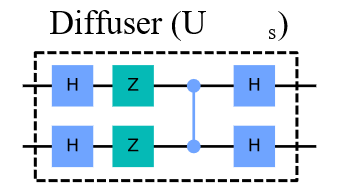

**تمرین:**

می‌دونیم که ضرب‌کردن وضعیت‌های عمود بر $|0 \rangle^{\otimes n}$ در $-1$ معادل ضرب کردن خود همین وضعیت در $-1$ه. (با حساب نکردن یه فاز کلی $-1$) یعنی داریم:

$$
U_0 \big( |0 \dots 0 \rangle + \dots + |1 \dots 1 \rangle \big) = \big( |0 \dots 0 \rangle - \dots - |1 \dots 1 \rangle \big) = - \big( -|0 \dots 0 \rangle + \dots + |1 \dots 1 \rangle \big)
$$

تابعی بنویسید که عدد $n$ رو بگیره و مدار کوانتومی $n$ کیوبیتی‌ای تولید کنه که عملگر Diffuser (یعنی $U_S$) رو روی کیوبیت‌هاش اعمال کنه.
(و در انتها این مدار رو به صورت یه گیت برگردونه، که کدش رو براتون گذاشتیم.)

**جواب:**

یادتون باشه که $U_S$ رو از روی $U_0$ می‌ساختیم:

$$ U_s = H^{\otimes n} U_0 H^{\otimes n} $$

و یک گیت $Z$ چند-کنترلی، ($MCZ$) فاز این وضعیت رو معکوس می‌کنه:  $|11\dots 1\rangle$

$$
MCZ = 
\begin{bmatrix}
 1 & 0 & 0 & \cdots & 0 \\
 0 & 1 & 0 & \cdots & 0 \\
 \vdots & \vdots & \vdots & \ddots & \vdots \\
 0 & 0 & 0 & \cdots & -1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\leftarrow \text{Add negative phase to} \; |11\dots 1\rangle\\
\end{aligned}
$$

اگه روی همه‌ی کیوبیت‌ها X بزنیم خواهیم داشت:

$$
\begin{aligned}
|00\dots 0\rangle & \rightarrow |11\dots 1\rangle\\
|11\dots 1\rangle & \rightarrow |00\dots 0\rangle
\end{aligned}
$$

پس:

$$ U_0 = - X^{\otimes n} (MCZ) X^{\otimes n} $$

با استفاده از همه‌ی این‌ها، می‌تونیم $U_s$ رو با استفاده از گیت‌های $H$, $X$ و یک گیت $Z$ چند کنترلی بسازیم:

$$ U_s = - H^{\otimes n} U_0 H^{\otimes n} = H^{\otimes n} X^{\otimes n} (MCZ) X^{\otimes n} H^{\otimes n} $$
   

In [2]:
def diffuser(n):
    qc = QuantumCircuit(n)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(n):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(n):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(n):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(n):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

## ۲. سودوکو

تا این‌جا، اوراکل‌هایی که داشتیم شکل خاصی داشتن (یعنی مثلا می‌گفتیم `0101` یا هرچیزی)، ولی بعضی وقتا اوراکل‌مون جوریه که فقظ استیت‌هایی که شرایط خاصی دارن رو تحت تاثیر قرار می‌ده، ولی لزومی نداره حتما یک سری استیت تعیین شده رو Mark کنه.

حالا فرض کنید می‌خوایم یه سودوکودی 2x2ی باینری رو حل کنیم (یعنی سلول‌هاش فقط مقادیر ۰ و ۱ رو می‌گیرن).

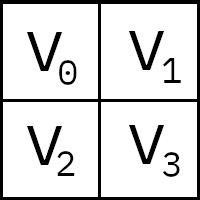

قوانین سودوکو به این صورتن: 

۱. هیچ ستونی نمی‌تونه یه مقدار رو دو بار داشته باشه.

۲. هیچ سطری نمی‌تونه یه مقدار رو دو بار داشته باشه.

درسته که می‌تونید جواب این سوال رو به راحتی توی ذهن‌تون پیدا کنید، ولی نکته‌ی سوال اینه که این‌جا یه جواب منحصربه‌فرد وجود نداره و Oracleمون می‌تونه چند حالت متفاوت رو Mark کنه.

به طور دقیق‌تر، این‌جا ۴تا شرط داریم که می‌خوایم چک‌شون کنیم:

```
v0 ≠ v1   # شرط سطر بالایی
v2 ≠ v3   # شرط سطر پایینی
v0 ≠ v2   # شرط ستون چپی
v1 ≠ v3   # شرط ستون راستی
```

پس برای راحتی، همین اول کار این شرط‌ها رو به این صورت وارد کد می‌کنیم:

In [1]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

### یه سری تمرین:

#### ۱.
تابعی بنویسید که یه مدار حاوی سه کیوبیت a, b, output رو بگیره و جواب XOR دو کیوبیت a, b رو در کیوبیت output قرار بده:

In [7]:
def XOR(qc: QuantumCircuit, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

**نکته: روش جدید برای ساخت مدار کوانتومی**

اون روشی که توی جلسات هندز-آن یک‌شنبه برای ساخت مدار کوانتومی توی Qiskit دیدیم، تنها راه موجود نیست و یکی دوتا راه دیگه (از لحاظ کد و خوانا بودن کد متفاوت ولی در عمل تقریبا یکسان) هم براش وجود داره.

این روش مبتنی بر اینه که می‌خوایم کیوبیت‌های مختلف‌مون رو در دسته‌هایی مجزا قرار بدیم که کار کردن باهاشون برامون راحت‌تر بشه. مثلا فرض کنید برای همین مدار XOR که ساختیم، می‌خوایم کیوبیت‌های a, b مون رو از کیوبیت output جدا کنیم. داریم:

Qubit(QuantumRegister(2, 'input'), 0)


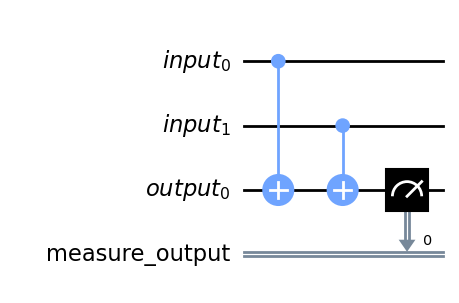

In [13]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
measure_qubit = ClassicalRegister(1, name='measure_output')
qc = QuantumCircuit(in_qubits, out_qubit, measure_qubit)
print(in_qubits[0])
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.measure(out_qubit, measure_qubit)
qc.draw(output="mpl")

#### ۲.

با استفاده از چیزایی که تا الان یاد گرفتید، تابعی بنویسید که مدار کوانتومی `qc` رو به صورتی تغییر بده که این مدار، برای سودوکویی که تعریف کردیم، Oracleای باشه که یه سری کیوبیت رو توی یه رجیستر به عنوان ورودی در نظر می‌گیره و همه‌ی Clauseهایی که توی `clause_list`مون گذاشتیم رو روی کیوبیت‌های رجیستر `var_qubits`مون حساب کنه و بریزدشون توی کیوبیت‌های رجیستر `clause_qubits`.

In [ ]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

In [ ]:
def clause_part_of_oracle(qc: QuantumCircuit):
    # ENTER YOUR CODE HERE
    pass

In [ ]:
# Answer:
def clause_part_of_oracle(qc: QuantumCircuit)
    # Use XOR gate to check each clause
    for i, clause in enumerate(clause_list):
        XOR(qc, clause[0], clause[1], clause_qubits[i])

    qc.draw(output="mpl")

#### ۳.
توی این قسمت می‌خوایم مدار سوال قبل‌مون رو با این شرایط زیر تغییر بدیم:

۱. می‌خوایم یه کیوبیت جدید توی مدارمون داشته‌باشیم که فازش ضرب‌در $-1$ بشه در حالتی که همه‌ی Clauseها برقرارن و فازش تغییر نکنه در حالتی که حتی یکی از Clauseها هم برقرار نیست. (طبق تعریفی که از Oracle داشتیم)

۲. می‌خوایم وضعیت کیوبیت‌های میانی‌مون (یعنی `clause_qubits`) به حالت $|0 \rangle^{\otimes n}$ برگرده، چرا که قرار بود Oracleمون فقط فاز یک کیوبیت رو تغییر بده. 

کدهای سوال قبل رو کپی کنید و با یه سری تغییرات جزئی توش، کد جدید رو بنویسید.

In [27]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

def sudoku_oracle(qc: QuantumCircuit, clause_qubits, output_qubit):
    qc.x(output_qubit)
    
    # Compute clauses
    for i, clause in enumerate(clause_list):
        XOR(qc, clause[0], clause[1], clause_qubits[i])

    # Flip 'output' bit if all clauses are satisfied
    qc.mcp(np.pi, clause_qubits, output_qubit)

    qc.draw()

#### ۴.

توی این قسمت می‌خوایم الگوریتم رو کامل کنیم، با استفاده از عملگر کلی Diffuser و Oracleای که برای این مساله‌ی خاص پیدا کردید، یه الگوریتم Grover کامل بنویسید که مساله‌ی سودوکوی باینری رو حل کنه و جوابی که پیدا می‌کنه رو اندازه‌گیری کنه و نتیجه‌ش رو بریزه توی یه رجیستر کلاسیک.

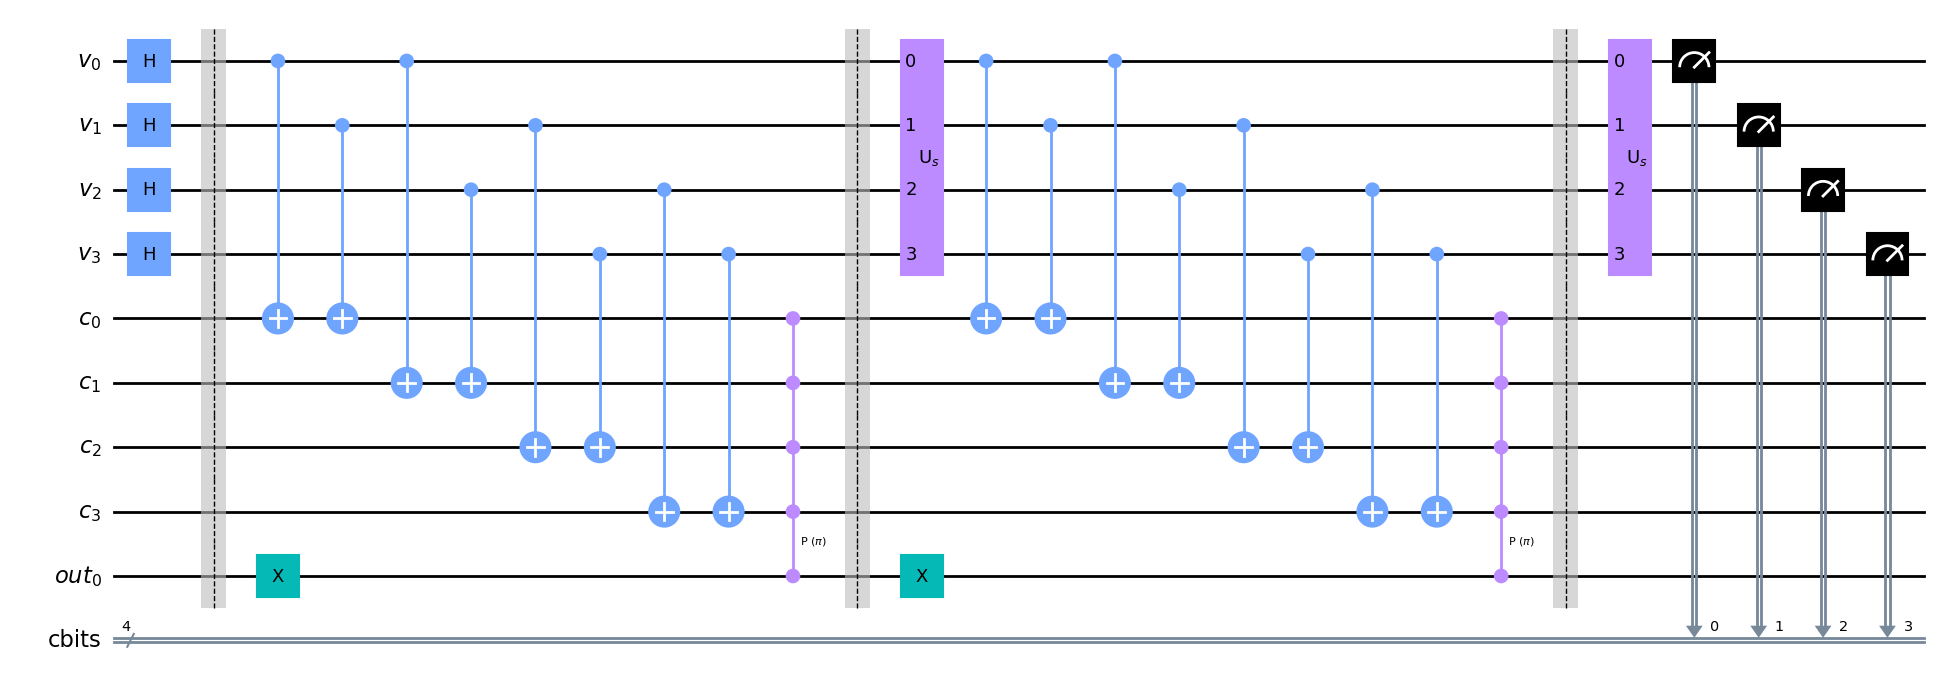

In [28]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_qubits, output_qubit)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_qubits, output_qubit)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1, output="mpl")

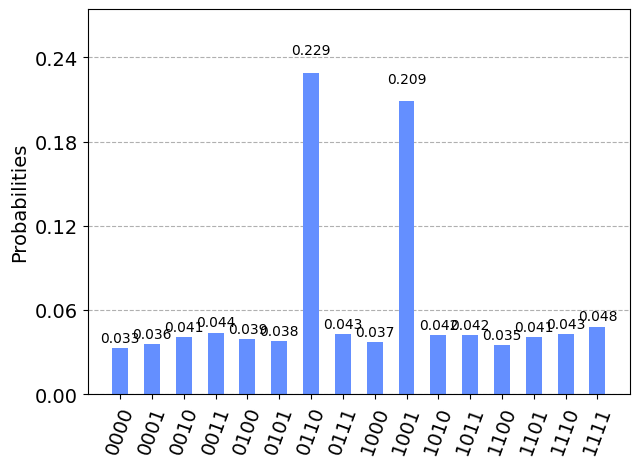

In [30]:
transpiled_qc = transpile(qc, sim)
qobj = assemble(transpiled_qc)
result = sim.run(qobj).result()
plot_histogram(result.get_counts())